![ICL](Images/imperiallogo.jpeg)

# Bayesian methods in ecology and evolution

https://bitbucket.org/mfumagal/statistical_inference

## day 4b: Bayesian estimation of speciation times

![](Images/PolarBear.jpg)

##### Preparation

For this practical you need some R packages, namely `coda`, `abc`, `maps`, `spam`, `fields`.
For plotting purposes you may also want to use `ggplot2`.

You will also need the software `ms` to be installed.
You can find the executable for linux in `bin/ms`.
If it doesn't work, you can compile the source `Software/ms.tar.gz` by
`tar -xzvf ms.tar.gz; cd msdir; gcc -o ms ms.c streec.c rand1.c -lm`.
Finally you need some data and R functions provided in `Data`.

I suggest to copy `functions.R` and `polar.brown.sfs*` in the workspace where you will run this practical without overwriting the repository.

You can work in teams for this practical. Actually, I encourage that you team up for this exercise (max 4 students per submission). Each student will have to submit her/his solution but with a clear indication of CID numbers of all members of the group.

##### Project

In this practical you are going to estimate the divergence (or speciation) time between polar bears and brown bears using genomics data. You will be using Approximate Bayesian Computation (ABC) methods to inference such time.

In [1]:
# Open R and load all R functions and data needed:
source("../Math/Data/functions.R")
load("../Math/Data/polar.brown.sfs.Rdata")

# Inspect the objects:
ls()

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 


[1] "calcGenoLikes"    "calcSummaryStats" "doFST"            "fold2DSFS"       
[5] "fromMStoSFS"      "plot2DSFS"        "polar.brown.sfs"  "reynolds"        
[9] "simulate"

The file `polar.brown.sfs` includes the joint (2 dimensions) site frequency
spectrum (SFS) between polar bears (on the rows) and brown bears (on the columns).
This is based on real genomic data from 18 polar bears and 7 brown bears.
The site frequency spectrum is a matrix $N \times M$ where cell $(i,j)$ reports the number of sites
with allele frequency $(i-1)$ in polar bears and $(j-1)$ in brown bears.
If you want to see this file type `cat polar.brown.sfs` in your terminal.

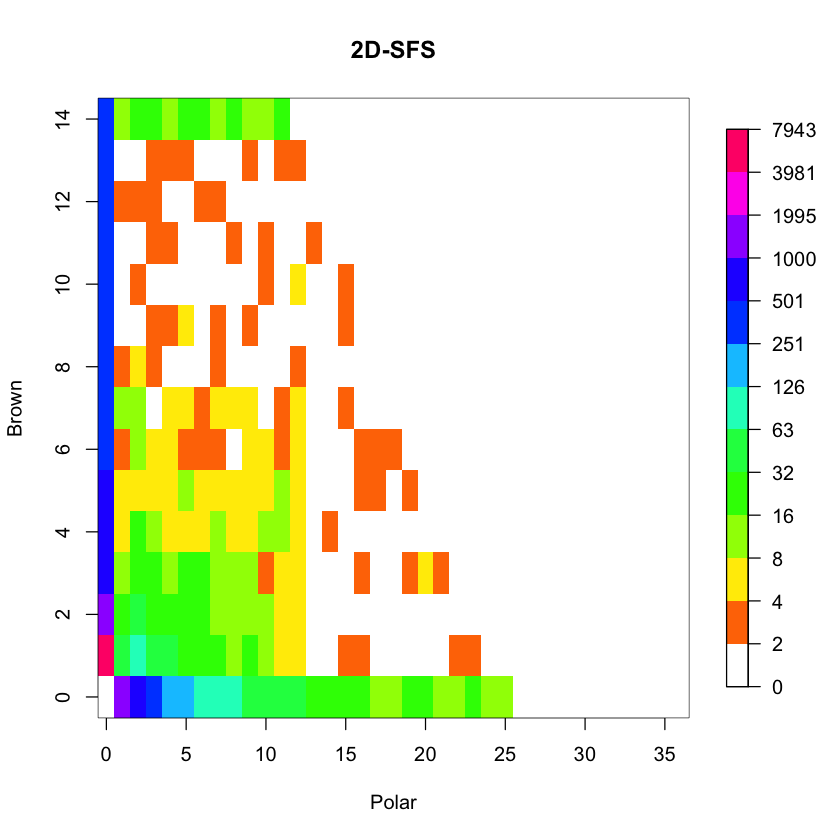

In [2]:
# You can plot this spectrum:
plot2DSFS(polar.brown.sfs, xlab="Polar", ylab="Brown", main="2D-SFS")

Each population has $2n+1$ entries in its spectrum, with $n$ being the number of individuals.
The number of chromosomes for each species (bears are diploids, like humans)
can be retrieved as:

In [3]:
nChroms.polar <- nrow(polar.brown.sfs)-1
nChroms.polar
nChroms.brown <- ncol(polar.brown.sfs)-1
nChroms.brown

[1] 36

[1] 14

The only thing you need to remember about the site frequency spectrum is that we
can easily calculate several summary statistics from it.
These summary statistics can be used for inferences in an Approximate Bayesian
Computation (ABC) framework.

For instance, from the site frequency spectrum, we can easily calculate the
number of analysed sites (in this example all sites are polymorphic, and thus
variable in our sample), which is simply the sum of all entries in the SFS.

In [4]:
nrSites <- sum(polar.brown.sfs, na.rm=T)
nrSites

[1] 16556

This value is important as we will condition the simulations to generate this
number of sites for each repetition.
In other words, when simulating data we will simulate exactly this number of
polymoprhic sites to calculate the site frequency spectrum and all
corresponding summary statistics afterwards.

I provide a function to easily calculate several summary statistics
from a site frequency spectrum.

In [5]:
obsSummaryStats <- calcSummaryStats(polar.brown.sfs)
obsSummaryStats
# These are the OBSERVED summary statistics! Keep them.

fst      pivar1      pivar2       sing1       sing2       doub1 
0.565642690 0.052449599 0.209206715 0.088487557 0.366634453 0.047052428 
      doub2         pef         puf 
0.094225658 0.008999758 0.991000242

These are the summary statistics available in this practical and their meaning
is the following:
* fst: population genetic differentiation; it measures how much species are genetically different; it goes from 0 (identical) to 1 (completely different);
* pivar1: genetic diversity of species 1 (polar bears);
* pivar2: genetic diversity of species 1 (brown bears);
* sing1: number of singletons (sites with frequency equal to 1) for species 1 (polar bears);
* sing2: number of singletons (sites with frequency equal to 1) for species 2 (brown bears);
* doub1: number of doubletons (sites with frequency equal to 2) for species 1 (polar bears);
* doub2: number of doubletons (sites with frequency equal to 2) for species 2 (brown bears);
* pef: proportion of sites with equal frequency between polar bears and brown bears;
* puf: proportion of sites with unequal frequency between polar bears and brown bears (note that puf=1-pef).

It is not important that you understand the significance (if any) of all these summary statistics in an evolutionary context.
If interested, a nice review is "Molecular Signatures of Natural Selection" by Rasmus Nielsen (you can find a pdf copy in `Readings/Papers/Nielsen_2005.pdf`).
However, some of these summary statistics might be more informative than others.
It is your first goal to understand which summary statistics to keep.

The parameter you want to estimate is the divergence time between polar and brown bears (T).
You first aim is to performs N simulations of data by drawing from a prior distribution of T and record (separately) the drawn values and the corresponding summary statistics generated by that value of T.

You can define how many simulations you want to perform (ideally a lot).

In [6]:
nrSimul <- 1e3 # but change this accordingly

Then you should define the prior distribution of our parameter to be estimated,
the divergence time T.
You can use any distribution you find suitable.
However, you may want to consider that a reasonable range of values for T is
between 200k and 700k years ago.

The function to simulate data (specifically the site frequency spectrum)
given values of T (and M, the migration rate) is `simulate`:

In [7]:
simulate

function (T, M, nr_snps, ms_dir, fout) 
{
    gen_time <- 8.423
    ref_pop_size <- 68000
    Tcoal <- T/(gen_time * ref_pop_size * 4)
    cat("", file = fout)
    ms.command <- paste(ms_dir, "50", nr_snps, "-s 1 -I 2 36 14 -n 1 1 -n 2 6.8 -en 0.02269 1 0.07353 -en 0.05281 2 0.2941 -em 0.06459 1 2", 
        M, "-em 0.1392 1 2 0 -en 0.1392 1 0.2941 -ej", Tcoal, 
        "2 1 -en 0.3924 1 1.809 >", fout)
    system(ms.command)
}

This function takes as parameters: T (divergence time), M (migration rate),
how many sites to simulate, the directory for `ms` program and the text file
in output.
This function simulates a joint evolutionary history for both polar and brown
bears according to what we know in terms of their respective changes in size.
However, you can set when they speciated (T in years ago) and the migration rate (M).
(Note that the migration rate is scaled by the reference population size
so a reasonable range of M is between 0 and 2.)

As an example, assuming T=200k and M=0 the command to simulate data and
calculate summary statistics is the following:

Warning message in readLines(msfile):
“line 194884 appears to contain an embedded nul”Warning message in matrix(sequencedata, nrow = (nr_chromosomes), ncol = (nr_repetitions)):
“data length [327188] is not a sub-multiple or multiple of the number of rows [50]”

fst     pivar1     pivar2      sing1      sing2      doub1      doub2 
0.46158690 0.13992266 0.10092075 0.39515198 0.19693472 0.09728101 0.05752212 
       pef        puf 
0.05662434 0.94337566

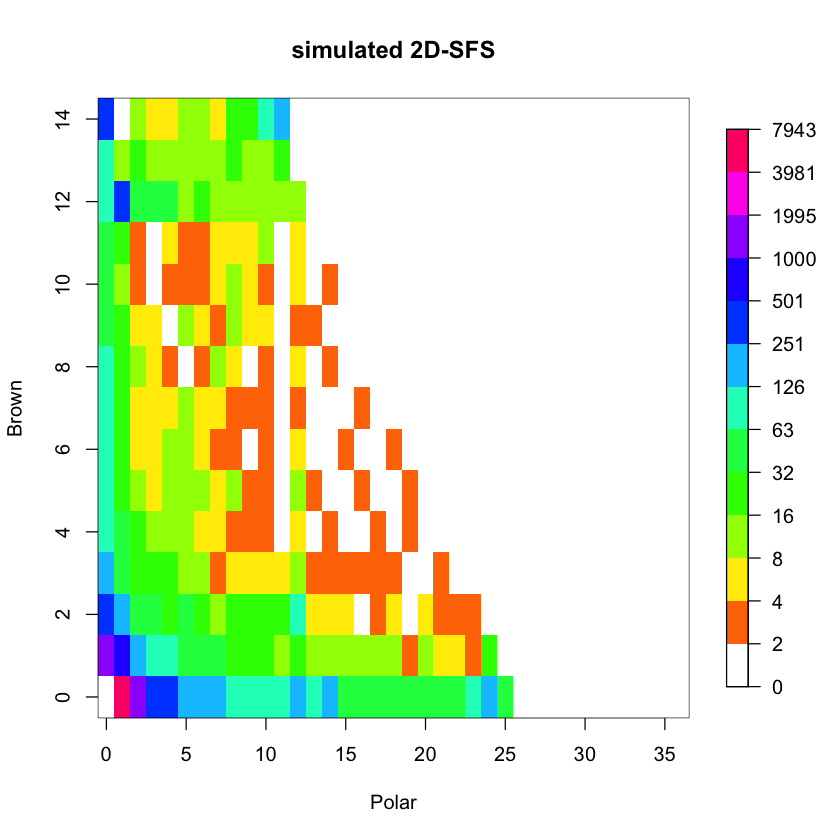

In [8]:
# first, set the path to the "ms" software you installed
msDir <- "Software/msdir/ms" # this is my specific case, yours could be different

# second, set the name for the output text file
fout <- "ms.txt" # leave it like here

# then we can simulate data:
simulate(T=2e5, M=0, nrSites, msDir, fout)

# and finally calculate the summary statistics for this simulation 
#(note that you need to specify the number of chromosomes for the two species)
simulatedSFS <- fromMStoSFS(fout, nrSites, nChroms.polar, nChroms.brown)
calcSummaryStats(simulatedSFS)

# you can even plot the simulated site frequency spectrum
plot2DSFS(simulatedSFS, xlab="Polar", ylab="Brown", main="simulated 2D-SFS")

Based on the observed summary statistics 'fst', which measures how different
polar and brown bears, in relation to the one calculated simulating T=2e5,
can you make some initial (very rough) considerations on the most likely values
of T (higher or lower than 200k years ago)?

You can use the `abc` package and the `abc` function to calculate the posterior
distribution (as well as to compute the distance between observed and expected summary statistics).

In [9]:
library(abc)
?abc

Loading required package: abc.data
Loading required package: nnet
Loading required package: quantreg
Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:spam’:

    backsolve

The following object is masked from ‘package:base’:

    backsolve

Loading required package: MASS
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22


As you can see, to perform an ABC analysis you need 3 objects:
* target: a vector of the observed summary statistics;
* param: a vector, matrix or data frame of the simulated parameter values;
* sumstat: a vector, matrix or data frame of the simulated summary statistics.

You already have 'target' as it is the vector of observed summary statistics
called 'obsSummaryStatistics'.

You now have everything to estimate the divergence time.
For simplicity assume that $M=0$.
Also, you are free to choose a rejection or local-regression method, as specified in the 'abc' function.
This is not strictly required, but if you want to explore the estimation of two parameters simultaneously, you can estimate M by defining a prior for it, draw random samples jointly of T and M, calculate summary statistics, and so on.

##### Hints

Please consider these points carefully when completing the project.
* Assess which summary statistics are more or less informative for the parameter estimation (e.g. after a first run of simulations with all parameters, look for correlations between the simulated parameter value and summary statistics).
* You can also look for correlations between summary statistics and eventually use only one of the pair if two summary statistics are highly correlated. If you are a pro, you can also perform a principal component or multidimensional scaling analysis (e.g. with package 'pls') and by using each statistic's loadings, you can create novel uncorrelated summary statistics which are linear combinations of the previous ones (this part is purely suggestive and it is not required to obtain the full score).
*  Remember to scale your simulated (jointly with the observed) summary statistics separately, so that the mean is zero and standard deviation is one.
*  Generate a plot with the posterior distribution of the parameter of interest. You can also show the chosen prior distribution on the same plot.
* Calculate the posterior mean, mode, median and  other notable quantities (e.g. 95% HPD interval) to summarise the posterior distribution.
* I suggest you to use the 'abc' package in R instead of implementing methods (e.g. regression) yourself.
* A useful diagnostic plot to show is the distribution of sampled values from the prior: do they cover the whole range of the prior (and are they distributed as expected)?


In [10]:
fout <- "ms.txt" # leave it like here
mat <- matrix(NA,nrow = nrSimul, ncol = 10)
nam <- c("fst", "pivar1", "pivar2", "sing1", "sing2", "doub1", "doub2","pef","puf","t")
colnames(mat) <- nam
for (i in 1:nrSimul){
  t= runif(1,2e5,7e5)
  # then we can simulate data:
  simulate(T=t, M=0, nrSites, msDir, fout)
  # and finally calculate the summary statistics for this simulation 
  #(note that you need to specify the number of chromosomes for the two species)
  simulatedSFS <- fromMStoSFS(fout, nrSites, nChroms.polar, nChroms.brown)
  x=calcSummaryStats(simulatedSFS)
  mat[i,1] <- x[1]
  mat[i,2] <- x[2]
  mat[i,3] <- x[3]
  mat[i,4] <- x[4]
  mat[i,5] <- x[5]
  mat[i,6] <- x[6]
  mat[i,7] <- x[7]
  mat[i,8] <- x[8]
  mat[i,9] <- x[9]
  mat[i,10] <- t
}

Warning message in matrix(sequencedata, nrow = (nr_chromosomes), ncol = (nr_repetitions)):
“data length [827799] is not a sub-multiple or multiple of the number of rows [50]”Warning message in matrix(sequencedata, nrow = (nr_chromosomes), ncol = (nr_repetitions)):
“data length [827787] is not a sub-multiple or multiple of the number of rows [50]”

ERROR: Error in sfs[daf_pop1, daf_pop2]: subscript out of bounds
